# Kuramoto-Sivashinsky Equation Energy-Preserving Operator Inference

ATTENTION: You will need at least 90GB of memory to run this notebook

In [1]:
using DataFrames
using FFTW
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using ProgressMeter
using SparseArrays
using Statistics
using StatsBase

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# Settings for the KS equation
KSE = KS(
    [0.0, 22.0], [0.0, 300.0], [1.0, 1.0],
    512, 0.001, 1, "ep"
)

# WARNING:DO YOU WANT TO SAVE DATA?
save_data = true

# Create file name to save data
datafile = "data/kse_data_L22.jld2"
opfile = "data/kse_operators_L22.jld2"
resultfile = "data/kse_results_L22.jld2"

# Settings for Operator Inference
KSE_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
KSE_vars = LnL.vars(
    N=1,
)
KSE_data = LnL.data(
    Δt=KSE.Δt,
    DS=100,
)
KSE_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=false,
    max_iter=1000,
    reproject=false,
    SIGE=false,
    with_bnds=true,
    linear_solver="ma86",
)

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
)

# Downsampling rate
DS = KSE_data.DS

# Down-sampled dimension of the time data
Tdim_ds = size(1:DS:KSE.Tdim, 1)  # downsampled time dimension

# Number of random test inputs
num_test_ic = 50

# Prune data to get only the chaotic region
prune_data = false
prune_idx = KSE.Tdim ÷ 2
t_prune = KSE.t[prune_idx-1:end]
;

## Generate Training Data

We use the initial condition of 

$$
\begin{gather*}
    u(x,0) = a\cos\left( \frac{2\pi x}{L} \right) + b\cos\left( \frac{4\pi x}{L} \right)
\end{gather*}
$$

where $a$ and $b$ are parameters that vary

In [3]:
# Parameters of the initial condition
ic_a = [0.8, 1.0, 1.2]
ic_b = [0.2, 0.4, 0.6]

num_ic_params = Int(length(ic_a) * length(ic_b))
L = KSE.Omega[2] - KSE.Omega[1]  # length of the domain

# Parameterized function for the initial condition
u0 = (a,b) -> a * cos.((2*π*KSE.x)/L) .+ b * cos.((4*π*KSE.x)/L)  # initial condition
;  

In [3]:
# Store values
Xtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training state data 
Rtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training derivative data
Xtr_all = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_ic_params)  # all training data
IC_train = Vector{Vector{Float64}}(undef, num_ic_params)  # all initial conditions 
Vr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # POD basis
Σr = Vector{Vector{Float64}}(undef, KSE.Pdim)  # singular values 
op_fom_tr = Vector{LnL.operators}(undef, KSE.Pdim)  # FOM operators 

@info "Generate the FOM system matrices and training data."
@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A, F = KSE.model_FD(KSE, μ)
    op_fom_tr[i] = LnL.operators(A=A, F=F)

    # Store the training data 
    Xall = Vector{Matrix{Float64}}(undef, num_ic_params)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ic_params)
    
    # Generate the data for all combinations of the initial condition parameters
    ic_combos = collect(Iterators.product(ic_a, ic_b))
    prog = Progress(length(ic_combos))
    Threads.@threads for (j, ic) in collect(enumerate(ic_combos))
        a, b = ic

        states = KSE.integrate_FD(A, F, KSE.t, u0(a,b))
        if prune_data
            Xtr_all[i,j] = states[:, prune_idx-1:end]

            tmp = states[:, prune_idx:end]
            Xall[j] = tmp[:, 1:DS:end]  # downsample data
            tmp = (states[:, prune_idx:end] - states[:, prune_idx-1:end-1]) / KSE.Δt
            Xdotall[j] = tmp[:, 1:DS:end]  # downsample data

            if i == 1
                IC_train[j] = states[:, prune_idx-1]
            end
        else
            Xtr_all[i,j] = states

            tmp = states[:, 2:end]
            Xall[j] = tmp[:, 1:DS:end]  # downsample data
            tmp = (states[:, 2:end] - states[:, 1:end-1]) / KSE.Δt
            Xdotall[j] = tmp[:, 1:DS:end]  # downsample data

            if i == 1
                IC_train[j] = u0(a, b)
            end
        end

        next!(prog)
    end
    # Combine all initial condition data to form on big training data matrix
    Xtr[i] = reduce(hcat, Xall) 
    Rtr[i] = reduce(hcat, Xdotall)
    
    # Compute the POD basis from the training data
    tmp = svd(Xtr[i])
    Vr[i] = tmp.U
    Σr[i] = tmp.S
end


┌ Info: Generate the FOM system matrices and training data.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:10


Progress:  22%|██████████                               |  ETA: 1:51:56

Progress:  67%|████████████████████████████             |  ETA: 0:16:05

Progress:  78%|████████████████████████████████         |  ETA: 0:09:12

Progress:  89%|█████████████████████████████████████    |  ETA: 0:04:02

Progress: 100%|█████████████████████████████████████████| Time: 0:32:18


### Check Energy-Levels from SVD and Decide Reduced Orders

In [4]:
nice_orders_all = Vector{Vector{Int}}(undef, KSE.Pdim)
energy_level_all = Vector{Vector{Float64}}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    nice_orders_all[i], energy_level_all[i] = LnL.choose_ro(Σr[i]; en_low=-12)
end
nice_orders = Int.(round.(mean(nice_orders_all)))
energy_level = mean(energy_level_all)
;

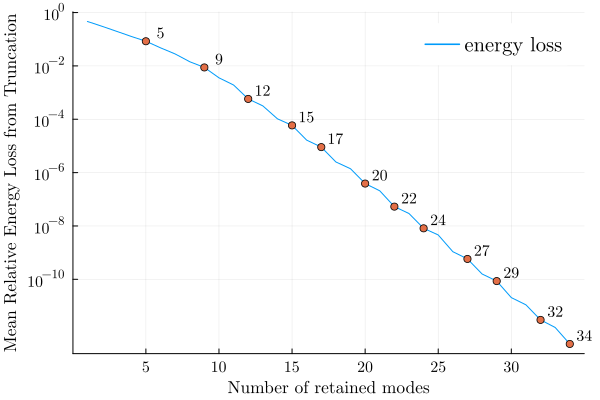

In [7]:
plot(energy_level[1:nice_orders[end]], yaxis=:log10, label="energy loss", fontfamily="Computer Modern",
    ylabel="Mean Relative Energy Loss from Truncation", xlabel="Number of retained modes", legend=:topright, majorgrid=true, grid=true)
plot!(nice_orders, energy_level[nice_orders], seriestype=:scatter, label=nothing)
for i in 1:length(nice_orders)
    annotate!([(nice_orders[i]+1., energy_level[nice_orders[i]], text(nice_orders[i], :bottom, 10, "Computer Modern"))])
end
yticks!(10.0 .^ (0:-2:-10))
plot!(fg_legend=:false)
plot!(guidefontsize=11, tickfontsize=10,  legendfontsize=13, right_margin=2mm)

**Based on the energy levels we select an appropriate reduced-order**

In [8]:
# Minimum and maximum dimensions
ro = nice_orders[2:8]
;

### Save data

In [9]:
if save_data
    save(
        datafile,
        Dict("Xtr" => Xtr, "Rtr" => Rtr, "Vr" => Vr, 
            "op_fom_tr" => op_fom_tr, "Σr" => Σr,
            "Xtr_all" => Xtr_all, "IC_train" => IC_train,
            "ro" => ro
        )
    )
end

## Obtain Operators using Least-Squares (Vanilla) Operator Inference

In [4]:
Xtr = DATA["Xtr"]
Rtr = DATA["Rtr"]
ro = DATA["ro"]
Vr = DATA["Vr"]
op_fom_tr = DATA["op_fom_tr"];

In [5]:
DATA = nothing

In [13]:
GC.gc()

In [7]:
@info "Compute the Least Squares solution."
options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    # with_tol=true,
    # pinv_tol=1e-4,
    λ=LnL.λtik(       # regularization parameter
        lin=0,
        quad=0,
    ),         
)

# Store values
op_LS = Array{LnL.operators}(undef, KSE.Pdim)

@showprogress for i in eachindex(KSE.μs)
    op_LS[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
end

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


## Compute intrusive operators

In [8]:
@info "Compute the intrusive model"

# Store values
op_int = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(op_fom_tr[i], Vr[i][:, 1:ro[end]], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:9


## Compute EPHEC-OpInf operators

In [9]:
@info "Compute the EPHEC model"

options = LnL.EPHEC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_ephec =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_ephec[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the EPHEC model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:24


┌ Info: Add constraints
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:112


┌ Info: Set objective
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:130


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:165



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:210607200
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   648000

Total number of variables............................:   655776
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     7776
                     variables with only upper bounds:        0
Total number of equality constraints.................:   650600
Total number of inequality constrain

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 24
│ solve time           = 2167.3430001735687
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 0.3554937706561646
│ objective_value      = 0.17774689008500838
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:167


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:187
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:15


## Compute EPSIC-Opinf operators

In [ ]:
@info "Compute the EPSIC OpInf."

options = LnL.EPSIC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    ϵ=1e-3,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_epsic = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epsic[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

## Compute EPP-OpInf operators

In [ ]:
@info "Compute the EPUC OpInf."

options = LnL.EPP_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    α=1e6,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_epp =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epp[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

## Save the operators

In [12]:
if save_data
    save(
        opfile,
        Dict("op_LS" => op_LS, "op_int" => op_int, "op_ephec" => op_ephec)
    )
end

## Analyze Training Results

### Load the data

In [2]:
DATA = load(datafile);

In [3]:
OPS = load(opfile);

In [4]:
RES = load(resultfile)
RES = Dict{String, Any}(RES); # convert type to avoid errors

In [13]:
# Setup the results
RES = Dict{String, Any}()
RES["train_proj_err"] = Array{Float64}(undef, length(ro), KSE.Pdim) 
RES["train_state_err"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
)
RES["train_CR"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
    :fom => Array{Float64}(undef, KSE.Pdim)
)
RES["train_AC"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
RES["train_LE"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
RES["train_DKY"] = Dict(
    :int   => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Float64}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Float64}(undef, KSE.Pdim)
)
RES["train_LE_all"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
;

In [14]:
function analyze_proj_err(model, X_all, Vr_all, IC, ro)
    num_ic_params = length(IC)
    PE_all = Array{Float64}(undef, length(ro), model.Pdim) 
    PE = Array{Float64}(undef, num_ic_params)  
    
    for i in eachindex(model.μs)
        prog = Progress(length(ro))
        for (j,r) in enumerate(ro)
            Vr = Vr_all[i][:, 1:r]
            Threads.@threads for (ct, ic) in collect(enumerate(IC))
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)
            end
            PE_all[j, i] = mean(PE)
        next!(prog)
        end
    end
    return PE_all
end

analyze_proj_err (generic function with 1 method)

In [15]:
function analyze_rse(op, model, X_all, Vr_all, IC, ro, DS, integrator)
    num_ic_params = length(IC)
    # Relative state error
    RSE_all = Array{Float64}(undef, length(ro), model.Pdim)
    RSE = Array{Float64}(undef, num_ic_params)

    for i in eachindex(model.μs)
        prog = Progress(length(ro))
        for (j,r) in enumerate(ro)
            Vr = Vr_all[i][:, 1:r]
            Threads.@threads for (ct, ic) in collect(enumerate(IC))
                Fextract = LnL.extractF(op[i].F, r)
                X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * ic)
                RSE[ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], X[:, 1:DS:end], Vr)
            end
            RSE_all[j, i] = mean(RSE)
            next!(prog)
        end
    end
    return RSE_all
end

analyze_rse (generic function with 1 method)

In [16]:
function analyze_cr(op, ForH, model, IC, ro)
    num_ic_params = length(IC)
    CR_all = Array{Float64}(undef, length(ro), model.Pdim)
    CR = Vector{Float64}(undef, num_ic_params)

    for i in eachindex(model.μs)
        for (j,r) in collect(enumerate(ro))
            for (ct, ic) in enumerate(IC)
                Fextract = LnL.extractF(op[i].F, r)
                CR[ct] =  LnL.constraintResidual(Fextract, r, ForH; with_mmt=false)
            end
            CR_all[j, i] = mean(CR)
        end
    end
    return CR_all
end

analyze_cr (generic function with 1 method)

In [17]:
function fom_CR(op, ForH, model)
    CR = Array{Float64}(undef, model.Pdim)

    for i in 1:length(model.μs)
        F_full = op[i].F
        CR[i] = LnL.constraintResidual(F_full, size(F_full, 1), ForH; with_mmt=false)
    end
    return CR
end

fom_CR (generic function with 1 method)

In [21]:
# Compute CR of full order model
RES["train_CR"][:fom] = fom_CR(DATA["op_fom_tr"], "F", KSE)

1-element Vector{Float64}:
 5.329070518200751e-15

In [ ]:
# Data["train_proj_err"], Data["train_state_err"], Data["train_En"], Data["train_CR"], Data["train_mmt"], Data["train_CV"] = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"],rmin,rmax)
Data = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"];ro=Data["ro"])

### Projection error

In [22]:
RES["train_proj_err"] = analyze_proj_err(KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"]);

Progress:  29%|████████████                             |  ETA: 0:00:24

Progress:  43%|██████████████████                       |  ETA: 0:00:19

Progress:  57%|████████████████████████                 |  ETA: 0:00:16

Progress:  71%|██████████████████████████████           |  ETA: 0:00:11

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:06

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


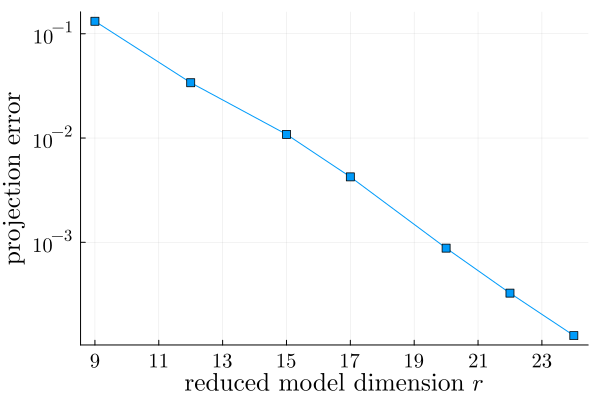

In [23]:
# Training data
mean_train_proj_err = mean(RES["train_proj_err"], dims=2)
plot(DATA["ro"], mean_train_proj_err, marker=(:rect), fontfamily="Computer Modern")
plot!(yscale=:log10, majorgrid=true, legend=false)
yticks!([1e-1, 1e-2, 1e-3, 1e-4])
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
xlabel!("reduced model dimension " * L"r")
ylabel!("projection error")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

### Relative state error

In [24]:
# Least-squares
RES["train_state_err"][:LS] = analyze_rse(OPS["op_LS"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:34

Progress:  43%|██████████████████                       |  ETA: 0:00:30

Progress:  57%|████████████████████████                 |  ETA: 0:00:22

Progress:  71%|██████████████████████████████           |  ETA: 0:00:15

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:07

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


In [25]:
# Intrusive
RES["train_state_err"][:int] = analyze_rse(OPS["op_int"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:30

Progress:  43%|██████████████████                       |  ETA: 0:00:29

Progress:  57%|████████████████████████                 |  ETA: 0:00:21

Progress:  71%|██████████████████████████████           |  ETA: 0:00:15

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:07

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


In [26]:
# EPHEC
RES["train_state_err"][:ephec] = analyze_rse(OPS["op_ephec"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:30

Progress:  43%|██████████████████                       |  ETA: 0:00:28

Progress:  57%|████████████████████████                 |  ETA: 0:00:21

Progress:  71%|██████████████████████████████           |  ETA: 0:00:14

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:07

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


In [ ]:
# EPSIC
RES["train_state_err"][:epsic] = analyze_rse(OPS["op_epsic"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

In [ ]:
# EPP
RES["train_state_err"][:epp] = analyze_rse(OPS["op_epp"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

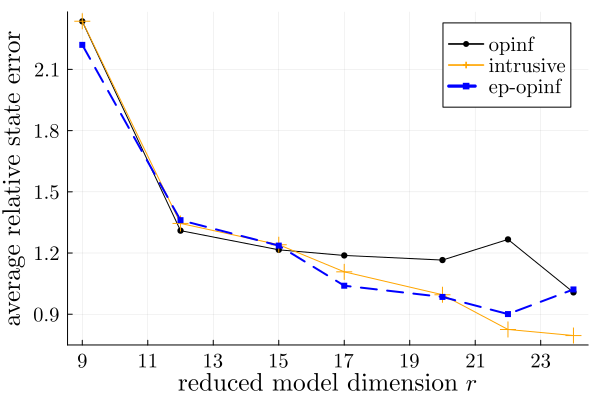

In [28]:
mean_LS_state_err = mean(RES["train_state_err"][:LS], dims=2)
mean_int_state_err = mean(RES["train_state_err"][:int], dims=2)
mean_ephec_state_err = mean(RES["train_state_err"][:ephec], dims=2)
# mean_epsic_state_err = mean(RES["train_state_err"][:epsic], dims=2)
# mean_epp_state_err = mean(RES["train_state_err"][:epp], dims=2)

plot(DATA["ro"], mean_LS_state_err, c=:black, marker=(:circle, 3.5, :black), label="opinf")
plot!(DATA["ro"], mean_int_state_err, c=:orange, marker=(:cross, 8, :orange), label="intrusive")
plot!(DATA["ro"], mean_ephec_state_err, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="ep-opinf")
# plot!(DATA["ro"], mean_epsic_state_err, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(DATA["ro"], mean_epp_state_err, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(majorgrid=true, legend=:topright)
# yticks!([1e-0, 1e-1])
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
xlabel!("reduced model dimension " * L" r")
ylabel!("average relative state error")
plot!(guidefontsize=16, tickfontsize=13, legendfontsize=13, fontfamily="Computer Modern")


### Constraint Residual

In [30]:
# Least-squares
RES["train_CR"][:LS] = analyze_cr(OPS["op_LS"], "F", KSE, DATA["IC_train"], DATA["ro"])
# Intrusive
RES["train_CR"][:int] = analyze_cr(OPS["op_int"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPHEC
RES["train_CR"][:ephec] = analyze_cr(OPS["op_ephec"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPSIC
# RES["train_CR"][:epsic] = analyze_cr(OPS["op_epsic"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPP
# RES["train_CR"][:epp] = analyze_cr(OPS["op_epp"], "F", KSE, DATA["IC_train"], DATA["ro"]);
;

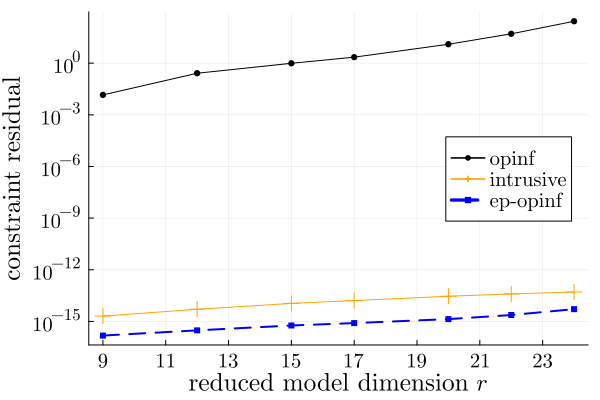

In [34]:
mean_LS_CR_tr = mean(RES["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(RES["train_CR"][:int], dims=2)
mean_ephec_CR_tr = mean(RES["train_CR"][:ephec], dims=2)
# mean_epsic_CR_tr = mean(RES["train_CR"][:epsic], dims=2)
# mean_epp_CR_tr = mean(RES["train_CR"][:epp], dims=2)

plot(DATA["ro"], mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label="opinf")
plot!(DATA["ro"], mean_int_CR_tr, c=:orange, marker=(:cross, 8), label="intrusive")
plot!(DATA["ro"], mean_ephec_CR_tr, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), lw=2, ls=:dash, label="ep-opinf")
# plot!(DATA["ro"], mean_epsic_CR_tr, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(DATA["ro"], mean_epp_CR_tr, c=:red, markerstrokecolor=:red, marker=(:star, 4), ls=:dash, lw=1, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:right, minorgridalpha=0.03)
yticks!(10.0 .^ [-15, -12, -9, -6, -3, 0, 3])
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
xlabel!("reduced model dimension " * L" r")
ylabel!("constraint residual")
plot!(guidefontsize=16, tickfontsize=13, legendfontsize=13, fontfamily="Computer Modern")

### Autocorrelation

In [8]:
# For one initial condition
function analyze_autocorr(op, model, Vr_all, IC, ro, integrator, lags)

    # auto_correletion
    auto_correlation = Array{Array{Float64}}(undef, length(ro), model.Pdim)

    for i in eachindex(model.μs)
        # prog = Progress(length(ro))
        Threads.@threads for (j,r) in collect(enumerate(ro))
            Vr = Vr_all[i][:, 1:r]

            Fextract = LnL.extractF(op[i].F, r)
            X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * IC)
            Xrecon = Vr * X
            auto_correlation[j, i] = tmean_autocorr(Xrecon, lags)
            # next!(prog)
        end
    end
    return auto_correlation
end


# For one initial condition for full-order model
function analyze_autocorr(model::Abstract_Models, X_all::AbstractArray, IC_idx::Int64, lags::AbstractArray)
    # auto_correletion
    auto_correlation = Array{Array{Float64}}(undef, model.Pdim)

    # prog = Progress(length(model.μs))
    Threads.@threads for i in eachindex(model.μs)
        auto_correlation[i] = tmean_autocorr(X_all[i,IC_idx], lags)
        # next!(prog)
    end
    return auto_correlation
end


function tmean_autocorr(X::AbstractArray, lags::AbstractVector)
    N, K = size(X)
    M = length(lags)
    Cx = zeros((N, M))
    
    for i in 1:N  # normalzied autocorrelation
        Cx[i,:] = autocor(X[i,:], lags)
    end
    return vec(mean(Cx, dims=1))
end


# Compute the relative error of the autocorrelation for each reduced dimensions
function autocorr_rel_err(AC, AC_fom, cutoff)
    rdim, pdim = size(AC)
    AC_rel_err = Array{Float64}(undef, rdim)
    for i in 1:rdim
        err = 0
        for j in 1:pdim
            ac = AC[i,j][1:cutoff]
            ac_fom = AC_fom[j][1:cutoff]
            err += norm(ac - ac_fom, 2) / norm(ac_fom, 2)
        end
        AC_rel_err[i] = err / pdim
    end
    return AC_rel_err
end
;

In [6]:
lags = 0:KSE_data.DS:Int(floor(KSE.Tdim));

In [ ]:
# FOM
foo = zeros(length(lags))
bar = length(DATA["IC_train"])
prog = Progress(bar)
for (i,initcond) in enumerate(DATA["IC_train"])
    foo .+= analyze_autocorr(KSE, DATA["Xtr_all"], i, lags)[1]
    next!(prog)
end
RES["train_AC"][:fom][1] = foo / bar

In [197]:
# Least-squares
foo = zeros(length(lags), length(DATA["ro"]))
bar = length(DATA["IC_train"])
prog = Progress(bar)
for (i, initcond) in enumerate(DATA["IC_train"])
    tmp = analyze_autocorr(OPS["op_LS"], KSE, DATA["Vr"], initcond, DATA["ro"], KSE.integrate_FD, lags)
    for j in eachindex(DATA["ro"])
        foo[:,j] .+= tmp[j,1]
    end
    next!(prog)
end

for j in eachindex(DATA["ro"])
    RES["train_AC"][:LS][j,1] = foo[:,j] / bar
end

Progress:  29%|████████████                             |  ETA: 0:10:37

Progress:  43%|██████████████████                       |  ETA: 0:05:43

Progress:  57%|████████████████████████                 |  ETA: 0:03:14

Progress:  71%|██████████████████████████████           |  ETA: 0:01:44

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:44

Progress: 100%|█████████████████████████████████████████| Time: 0:04:23


Progress: 100%|█████████████████████████████████████████| Time: 0:39:01


In [204]:
# Intrusive
foo = zeros(length(lags), length(DATA["ro"]))
bar = length(DATA["IC_train"])
prog = Progress(bar)
for (i, initcond) in enumerate(DATA["IC_train"])
    tmp = analyze_autocorr(OPS["op_int"], KSE, DATA["Vr"], initcond, DATA["ro"], KSE.integrate_FD, lags)
    for j in eachindex(DATA["ro"])
        foo[:,j] .+= tmp[j,1]
    end
    next!(prog)
end

for j in eachindex(DATA["ro"])
    RES["train_AC"][:int][j,1] = foo[:,j] / bar
end

Progress:  22%|██████████                               |  ETA: 0:30:02

Progress:  33%|██████████████                           |  ETA: 0:25:56

Progress:  44%|███████████████████                      |  ETA: 0:21:40

Progress:  56%|███████████████████████                  |  ETA: 0:17:23

Progress:  67%|████████████████████████████             |  ETA: 0:13:03

Progress:  78%|████████████████████████████████         |  ETA: 0:08:42

Progress:  89%|█████████████████████████████████████    |  ETA: 0:04:21

Progress: 100%|█████████████████████████████████████████| Time: 0:39:06


In [206]:
# EPHEC
foo = zeros(length(lags), length(DATA["ro"]))
bar = length(DATA["IC_train"])
prog = Progress(bar)
for (i, initcond) in enumerate(DATA["IC_train"])
    tmp = analyze_autocorr(OPS["op_ephec"], KSE, DATA["Vr"], initcond, DATA["ro"], KSE.integrate_FD, lags)
    for j in eachindex(DATA["ro"])
        foo[:,j] .+= tmp[j,1]
    end
    next!(prog)
end

for j in eachindex(DATA["ro"])
    RES["train_AC"][:ephec][j,1] = foo[:,j] / bar
end

Progress:  22%|██████████                               |  ETA: 0:30:18

Progress:  33%|██████████████                           |  ETA: 0:25:55

Progress:  44%|███████████████████                      |  ETA: 0:21:37

Progress:  56%|███████████████████████                  |  ETA: 0:17:20

Progress:  67%|████████████████████████████             |  ETA: 0:13:01

Progress:  78%|████████████████████████████████         |  ETA: 0:08:42

Progress:  89%|█████████████████████████████████████    |  ETA: 0:04:21

Progress: 100%|█████████████████████████████████████████| Time: 0:39:14


In [ ]:
# EPSIC
RES["train_AC"][:epsic] = analyze_autocorr(OPS["op_epsic"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

In [ ]:
# EPP
RES["train_AC"][:epp] = analyze_autocorr(OPS["op_epp"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

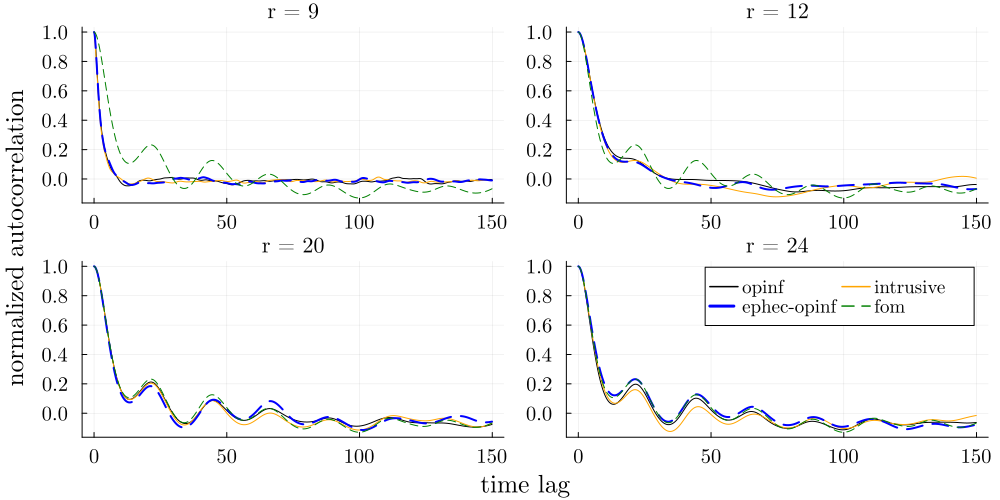

In [7]:
lags_t = collect(lags) .* KSE.Δt
idx = length(lags_t) ÷ 2
lout = @layout [grid(2,2)]
p = plot(layout=lout, size=(1000, 500))
for (plot_id, ri) in enumerate([1, 2, 5, 7])
    plot!(p[plot_id], lags_t[1:idx], RES["train_AC"][:LS][ri][1:idx], c=:black, label="opinf")
    plot!(p[plot_id], lags_t[1:idx], RES["train_AC"][:int][ri][1:idx], c=:orange, label="intrusive")
    plot!(p[plot_id], lags_t[1:idx], RES["train_AC"][:ephec][ri][1:idx], c=:blue, ls=:dash, lw=2, label="ephec-opinf")
    # plot!(p[plot_id], lags_t, RES["train_AC"][:epsic][ri], c=:purple, ls=:dot, label="epsic-opinf")
    # plot!(p[plot_id], lags_t, RES["train_AC"][:epp][ri], c=:red, lw=1, ls=:dash, label="epp-opinf")
    plot!(p[plot_id], lags_t[1:idx], RES["train_AC"][:fom][1][1:idx], c=:green, lw=1, ls=:dash, label="fom")
    plot!(p[plot_id], fontfamily="Computer Modern", guidefontsize=12, tickfontsize=13)
    plot!(p[plot_id], title="r = $(DATA["ro"][ri])", titlefontsize=14, titlefontfamily="Computer Modern")
    # xlabel!(p[plot_id], "lag")
    # ylabel!(p[plot_id], "normalized autocorrelation")
    yticks!(p[plot_id], [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if plot_id == 4
        plot!(p[plot_id], legend=:topright, legend_column=2, legendfontsize=12)
    else
        plot!(p[plot_id], legend=false)
    end
end
plot!(p[1], left_margin=9mm)
plot!(p[3], bottom_margin=9mm, left_margin=9mm)
plot!(p[4], bottom_margin=9mm)
annotate!(p[4], -20, -0.48, "time lag", annotationfontsize=16)
annotate!(p[1], -30, -0.4, Plots.text("normalized autocorrelation", 16, rotation=90, "Computer Modern"))
display(p)

In [9]:
LS_AC_over_r = autocorr_rel_err(RES["train_AC"][:LS], RES["train_AC"][:fom], idx)
int_AC_over_r = autocorr_rel_err(RES["train_AC"][:int], RES["train_AC"][:fom], idx)
ephec_AC_over_r = autocorr_rel_err(RES["train_AC"][:ephec], RES["train_AC"][:fom], idx)
# epsic_AC_over_r = autocorr_rel_err(RES["train_AC"][:epsic], RES["train_AC"][:fom])
# epp_AC_over_r = autocorr_rel_err(RES["train_AC"][:epp], RES["train_AC"][:fom])
;

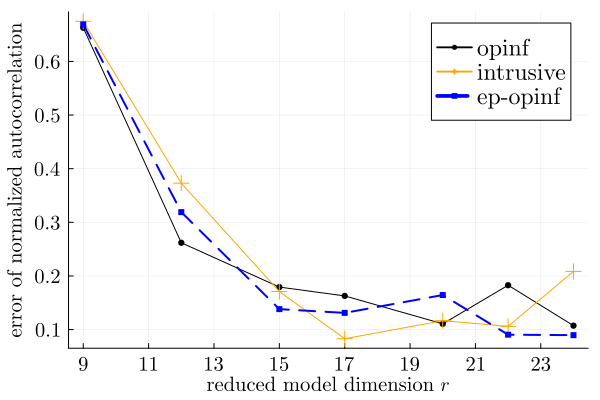

In [13]:
plot(DATA["ro"], LS_AC_over_r, c=:black, marker=(:circle, 3.5, :black), label="opinf")
plot!(DATA["ro"], int_AC_over_r, c=:orange, marker=(:cross, 8, :orange), label="intrusive")
plot!(DATA["ro"], ephec_AC_over_r, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="ep-opinf")
# plot!(DATA["ro"], epsic_AC_over_r, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label="epsic-opinf")
# plot!(DATA["ro"], epp_AC_over_r, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label="epp-opinf")

plot!(majorgrid=true, legend=:topright)
xlabel!("reduced model dimension " * L" r")
ylabel!("error of normalized autocorrelation")
# yticks!([1e-0, 1e-1, 1e-2, 1e-3])
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
plot!(left_margin=2mm)
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=15)


### Lyapunov Exponent

In [23]:
struct LE_options
    m::Int64         # the number of the most exponents to compute
    τ::Real          # time to simulate the system before computing exponents
    T::Real          # time between reorthogonalization steps
    N::Int64         # the total number of reorthogonalization steps
    ϵ::Real          # perturbation magnitude
    verbose::Bool    # print progress to stdout
    all::Bool        # return all LEs
end

In [39]:
function lyapunovExponent(
    model::Abstract_Models,  # dynamical model
    ops::LnL.operators,      # operators for the full/reduced model
    integrator::Function,    # integrator for the full/reduced model
    ic::AbstractArray,       # initial condition
    options::LE_options      # options for the algorithm
    )

    # Unpack options
    m = options.m
    τ = options.τ
    T = options.T
    N = options.N
    ϵ = options.ϵ

    nx = size(ic, 1)
    @assert m <= nx "m must be less than or equal to the dimension of the system"
    Δt = T <= model.Δt ? T/10 : model.Δt

    tmp = integrator(ops.A, ops.F, collect(model.T[1]:Δt:τ), ic)
    ujm1 = tmp[:, end]
    ujm2 = tmp[:, end-1]

    if options.all
        λ_all = zeros(m,N)  # all Lyapunov exponents
    end
    λ = zeros(m)         # Lyapunov exponents

    # Initialize the Q matrix
    # Q = 1.0I(nx)[:,1:m]  # orthogonal directions
    # Q = mapslices(x -> x / norm(x), svd(tmp).U[:,1:m], dims=1)  # orthogonal directions with SVD
    Q = randn(nx, m)     # orthogonal directions with random vectors

    if options.verbose
        prog = Progress(N)
    end
    tj = τ
    for j in 1:N
        ujm2_sq = LnL.vech(ujm2 * ujm2')
        uj = integrator(ops.A, ops.F, collect(tj:Δt:tj+T), ujm1; u2_lm1=ujm2_sq)[:,end]

        Threads.@threads for i in 1:m
            u_tjm1 = ujm1 + ϵ * Q[:,i]  # perturb the starting value
            wj_i = integrator(ops.A, ops.F, collect(tj:Δt:tj+T), u_tjm1; u2_lm1=ujm2_sq)[:,end]
            Q[:,i] = (wj_i - uj) / ϵ
        end
        QR = LinearAlgebra.qr(Q)
        Q = Matrix(QR.Q)  # update the Q matrix
        R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
        posDiag_QR!(Q, R) # make sure the diagonal of R is positive
        Q = Q[:, 1:m]     # truncate Q to the first m columns
        R = R[1:m, 1:m]   # truncate R to the first m rows and columns

        # add to the Lyapunov exponents
        λ .+= log.(diag(R))

        if options.all
            λ_all[:,j] = λ / j / T / Δt
        end

        # update values
        tj += T
        ujm2 = ujm1
        ujm1 = uj

        if options.verbose
            next!(prog)
        end
    end

    if options.all
        return λ / N / T / Δt, λ_all
    else
        return λ / N / T / Δt
    end
end

# Dispatch for ROM
function lyapunovExponent(
    model::Abstract_Models,  # dynamical model
    ops::LnL.operators,      # operators for the full/reduced model
    integrator::Function,    # integrator for the full/reduced model
    ic::AbstractArray,       # initial condition
    Vr::AbstractArray,       # basis for the reduced model
    options::LE_options      # options for the algorithm
    )

    # Unpack options
    m = options.m
    τ = options.τ
    T = options.T
    N = options.N
    ϵ = options.ϵ

    nx = size(ic, 1)
    @assert m <= nx "m must be less than or equal to the dimension of the system"
    Δt = T <= model.Δt ? T/10 : model.Δt

    ro = size(Vr, 2)
    if size(ops.A, 1) !== ro
        A = ops.A[1:ro, 1:ro]
        F = LnL.extractF(ops.F, ro)
    else
        A = ops.A
        F = ops.F
    end

    tmp = integrator(A, F, collect(model.T[1]:Δt:τ), Vr' * ic)
    ujm1 = tmp[:, end]      # u(j-1): dimension r << nx
    ujm2 = tmp[:, end-1]    # u(j-2): dimension r << nx
    ujm1_recon = Vr * ujm1  # u(j-1): dimension nx (reconstructed states)
    ujm2_recon = Vr * ujm2  # u(j-2): dimension nx (reconstructed states)

    if options.all
        λ_all = zeros(m, N)  # all Lyapunov exponents
    end
    λ = zeros(m)         # Lyapunov exponents

    # Initialize the Q matrix
    # Q = 1.0I(nx)[:,1:m]  # orthogonal directions
    # Q = mapslices(x -> x / norm(x), svd(tmp).U[:,1:m], dims=1)  # orthogonal directions with SVD
    Q = randn(nx, m)     # orthogonal directions with random vectors

    if options.verbose
        prog = Progress(N)
    end
    tj = τ
    for j in 1:N
        # Run the ROM
        ujm2_sq = LnL.vech(ujm2 * ujm2')
        uj = integrator(A, F, collect(tj:Δt:tj+T), ujm1; u2_lm1=ujm2_sq)[:,end]

        # Reconstruct the full order states
        uj_recon = Vr * uj

        Threads.@threads for i in 1:m
            u_tjm1 = ujm1_recon + ϵ * Q[:,i]  # perturb the starting value
            wj_i = integrator(A, F, collect(tj:Δt:tj+T), Vr' * u_tjm1; u2_lm1=ujm2_sq)[:,end]
            wj_i_recon = Vr * wj_i  # reconstruct the full order perturbed states
            Q[:,i] = (wj_i_recon - uj_recon) / ϵ
        end
        QR = LinearAlgebra.qr(Q)
        Q = Matrix(QR.Q)  # update the Q matrix
        R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
        posDiag_QR!(Q, R) # make sure the diagonal of R is positive
        Q = Q[:, 1:m]     # truncate Q to the first m columns
        R = R[1:m, 1:m]   # truncate R to the first m rows and columns

        # add to the Lyapunov exponents
        λ .+= log.(diag(R))

        if options.all
            λ_all[:,j] .= λ / j / T
        end

        # update values
        tj += T
        ujm2 = ujm1
        ujm1 = uj
        ujm1_recon = uj_recon

        if options.verbose
            next!(prog)
        end
    end

    if options.all
        return λ / N / T, λ_all
    else
        return λ / N / T
    end
end


function posDiag_QR!(Q::AbstractMatrix, R::AbstractMatrix)
    @assert size(Q, 2) == size(R, 2) "Q and R must have the same number of columns"

    m = size(Q, 2)
    for i in 1:m
        if R[i,i] < 0
            Q[:,i] = -Q[:,i]
            R[i,:] = -R[i,:]
        end
    end
end
;

In [ ]:
function rungeKutta4(A, F, x0, dt)
    N = size(A, 1)
    # Define the derivative function
    function dxdt(A, F, x)
        Ln = LnL.elimat(N)
        return A + F * Ln * kron(1.0I(N), x) + F * Ln * kron(x, 1.0I(N))
    end

    # RK4 steps
    k1 = dxdt(A, F, x0)
    k2 = dxdt(A, F, x0 + 0.5*dt*k1)
    k3 = dxdt(A, F, x0 + 0.5*dt*k2)
    k4 = dxdt(A, F, x0 + dt*k3)

    # Update the state
    x1 = x0 + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    return x1
end

# Dispatch for ROM
function lyapunovExponentJacobian(
    model::Abstract_Models,  # dynamical model
    ops::LnL.operators,      # operators for the full/reduced model
    integrator::Function,    # integrator for the full/reduced model
    ic::AbstractArray,       # initial condition
    Vr::AbstractArray,       # basis for the reduced model
    options::LE_options      # options for the algorithm
    )

    # Unpack options
    m = options.m
    τ = options.τ
    T = options.T
    N = options.N
    ϵ = options.ϵ

    nx = size(ic, 1)
    @assert m <= nx "m must be less than or equal to the dimension of the system"
    Δt = T <= model.Δt ? T/10 : model.Δt

    ro = size(Vr, 2)
    if size(ops.A, 1) !== ro
        A = ops.A[1:ro, 1:ro]
        F = LnL.extractF(ops.F, ro)
    else
        A = ops.A
        F = ops.F
    end

    tmp = integrator(A, F, collect(model.T[1]:Δt:τ), Vr' * ic)
    ujm1 = tmp[:, end]      # u(j-1): dimension r << nx

    if options.all
        λ_all = zeros(m, N)  # all Lyapunov exponents
    end
    λ = zeros(m)         # Lyapunov exponents

    # Initialize the Q matrix
    Q = randn(nx, m)     # orthogonal directions with random vectors

    if options.verbose
        prog = Progress(N)
    end
    tj = τ
    for j in 1:N
        # Run the ROM
        uj = integrator(A, F, collect(tj:Δt:tj+T), ujm1; u2_lm1=ujm2_sq)[:,end]

        # Reconstruct the full order states
        uj_recon = Vr * uj

        Threads.@threads for i in 1:m
            u_tjm1 = ujm1_recon + ϵ * Q[:,i]  # perturb the starting value
            wj_i = integrator(A, F, collect(tj:Δt:tj+T), Vr' * u_tjm1; u2_lm1=ujm2_sq)[:,end]
            wj_i_recon = Vr * wj_i  # reconstruct the full order perturbed states
            Q[:,i] = (wj_i_recon - uj_recon) / ϵ
        end
        QR = LinearAlgebra.qr(Q)
        Q = Matrix(QR.Q)  # update the Q matrix
        R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
        posDiag_QR!(Q, R) # make sure the diagonal of R is positive
        Q = Q[:, 1:m]     # truncate Q to the first m columns
        R = R[1:m, 1:m]   # truncate R to the first m rows and columns

        # add to the Lyapunov exponents
        λ .+= log.(diag(R))

        if options.all
            λ_all[:,j] .= λ / j / T
        end

        # update values
        tj += T
        ujm2 = ujm1
        ujm1 = uj
        ujm1_recon = uj_recon

        if options.verbose
            next!(prog)
        end
    end

    if options.all
        return λ / N / T, λ_all
    else
        return λ / N / T
    end
end


function posDiag_QR!(Q::AbstractMatrix, R::AbstractMatrix)
    @assert size(Q, 2) == size(R, 2) "Q and R must have the same number of columns"

    m = size(Q, 2)
    for i in 1:m
        if R[i,i] < 0
            Q[:,i] = -Q[:,i]
            R[i,:] = -R[i,:]
        end
    end
end
;

In [26]:
# One initial condition for ROM
function analyze_lyapExp(model, op, IC, Vr, ro, integrator, options)
    # Lypuanov Exponents
    LE = Array{Array{Float64}}(undef, length(ro), model.Pdim)
    LE_all = Array{Array{Float64}}(undef, length(ro), model.Pdim)

    for i in eachindex(model.μs)
        for (j,r) in enumerate(ro)
            if options.all
                LE[j,i], LE_all[j,i]  = lyapunovExponent(model, op[i], integrator, IC, Vr[i][:,1:r], options)
            else
                LE[j,i] = lyapunovExponent(model, op[i], integrator, IC, Vr[i][:,1:r], options)
            end
            @info "Reduced order of $(r) completed..."
        end
        @info "Loop $(i) out of $(model.Pdim) completed..."
    end
    if options.all
        return LE, LE_all
    else
        return LE
    end
end


# One initial condition for FOM
function analyze_lyapExp(model, op, IC, integrator, options)
    # auto_correletion
    LE = Array{Array{Float64}}(undef, model.Pdim)
    LE_all = Array{Array{Float64}}(undef, model.Pdim)

    for i in eachindex(model.μs)
        if options.all
            LE[i], LE_all[i] = lyapunovExponent(model, op[i], integrator, IC, options)
        else
            LE[i] = lyapunovExponent(model, op[i], integrator, IC, options)
        end
        @info "Loop $(i) out of $(model.Pdim) completed..."
    end
    if options.all
        return LE, LE_all
    else
        return LE
    end
end
;

In [40]:
le_option = LE_options(10, 1000, 0.05, 1000, 1e-6, false, true);

In [108]:
RES["train_LE"][:fom], RES["train_LE_all"][:fom] = analyze_lyapExp(KSE, DATA["op_fom_tr"], DATA["IC_train"][1], KSE.integrate_FD, le_option);

┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:79


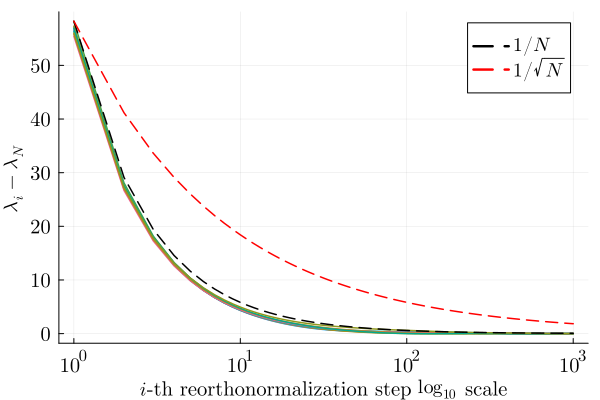

In [171]:
p = plot()
i_tmp = 1
foo, bar = size(RES["train_LE_all"][:fom][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:fom][i_tmp][i,:] .- RES["train_LE"][:fom][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:fom][i_tmp][end,:] .- RES["train_LE"][:fom][i_tmp][end], lw=1.5, label=false)
plot!(p, 1:bar, maximum(RES["train_LE_all"][:fom][i_tmp][:,1]) ./ (1:bar), c=:black, ls=:dash, lw=1.5, label=L"1/N")
plot!(p, 1:bar, maximum(RES["train_LE_all"][:fom][i_tmp][:,1]) ./ sqrt.(1:bar), c=:red, ls=:dash, lw=1.5, label=L"1/\sqrt{N}")
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthonormalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [109]:
RES["train_LE"][:LS], RES["train_LE_all"][:LS] = analyze_lyapExp(KSE, OPS["op_LS"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option);

┌ Info: Reduced order of 9 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 12 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 15 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 17 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 20 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 22 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 24 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:39


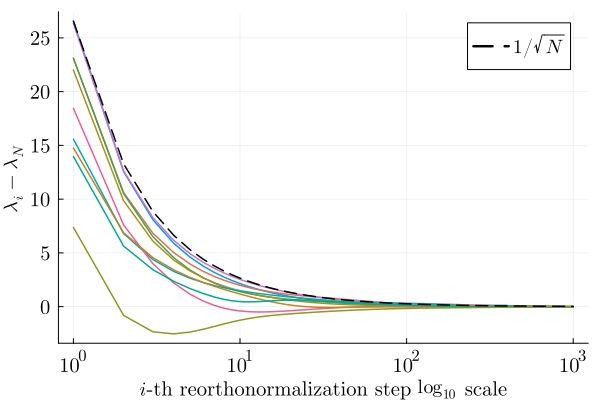

In [172]:
p = plot()
i_tmp = 7
foo, bar = size(RES["train_LE_all"][:LS][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:LS][i_tmp][i,:] .- RES["train_LE"][:LS][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:LS][i_tmp][end,:] .- RES["train_LE"][:LS][i_tmp][end], lw=1.5, label=false)
plot!(p, 1:bar, maximum(RES["train_LE_all"][:LS][i_tmp][:,1] .- RES["train_LE"][:LS][i_tmp]) ./ (1:bar), c=:black, ls=:dash, lw=1.5, label=L"1/\sqrt{N}")
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthonormalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [41]:
RES["train_LE"][:int], RES["train_LE_all"][:int] = analyze_lyapExp(KSE, OPS["op_int"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option);

┌ Info: Reduced order of 9 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 12 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 15 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 17 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 20 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 22 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14


┌ Info: Reduced order of 24 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:14
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:16


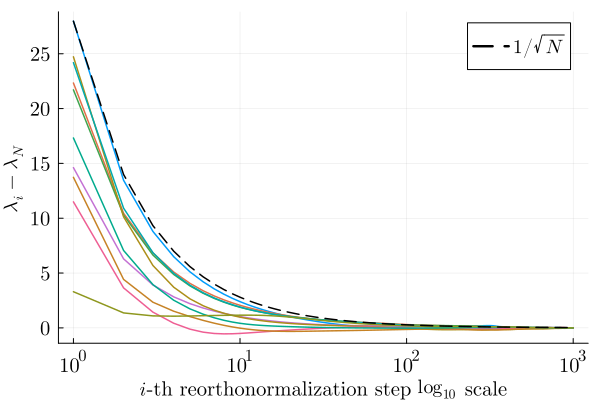

In [42]:
p = plot()
i_tmp = 7
foo, bar = size(RES["train_LE_all"][:int][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:int][i_tmp][i,:] .- RES["train_LE"][:int][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:int][i_tmp][end,:] .- RES["train_LE"][:int][i_tmp][end], lw=1.5, label=false)
plot!(p, 1:bar, maximum(RES["train_LE_all"][:int][i_tmp][:,1] .- RES["train_LE"][:int][i_tmp]) ./ (1:bar), c=:black, ls=:dash, lw=1.5, label=L"1/\sqrt{N}")
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthonormalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [111]:
RES["train_LE"][:ephec], RES["train_LE_all"][:ephec] = analyze_lyapExp(KSE, OPS["op_ephec"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option)

┌ Info: Reduced order of 9 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 12 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 15 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 17 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 20 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 22 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37


┌ Info: Reduced order of 24 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:37
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:39


(Array{Float64}[[0.33052204225171505, 0.07457855191592579, 0.019216735752997968, -0.03411079014970418, -0.15451514151212756, -0.2671224952831029, -0.40687750199050504, -0.6586850180971073, -0.7687744676248522, -371.24144099828885]; [0.0417806359236942, 0.027096496275252555, -0.013388794398195574, -0.06489865053628555, -0.1475099925820754, -0.1347453976270889, -0.1930337756865498, -0.2783561510065351, -1.8313596711875593, -1.8277020266490245]; … ; [0.07180013535222844, 0.013888330311588483, 0.018673296078561077, -0.029625298421838857, -0.17419685899991474, -0.29801335356220426, -0.24958472459747716, -0.316414277445289, -1.9662997483149838, -1.9417594550057933]; [0.06288864511309421, 0.07868291574157597, -0.03447795702721006, -0.0033018401405942636, -0.14831926272426119, -0.2808813787762111, -0.304480636811517, -0.3275476659197604, -1.8980821278826094, -1.9333769410508608];;], Array{Float64}[[23.43587678963005 11.652292609665293 … 0.3305752767373724 0.33052204225171505; 21.09348208185423

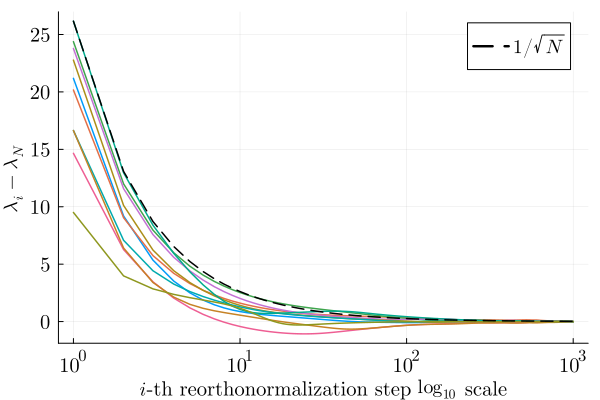

In [178]:
p = plot()
i_tmp = 3
foo, bar = size(RES["train_LE_all"][:ephec][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:ephec][i_tmp][i,:] .- RES["train_LE"][:ephec][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:ephec][i_tmp][end,:] .- RES["train_LE"][:ephec][i_tmp][end], lw=1.5, label=false)
plot!(p, 1:bar, maximum(RES["train_LE_all"][:ephec][i_tmp][:,1] .- RES["train_LE"][:ephec][i_tmp]) ./ (1:bar), c=:black, ls=:dash, lw=1.5, label=L"1/\sqrt{N}")
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthonormalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [ ]:
RES["train_LE"][:epsic], RES["train_LE_all"][:epsic] = analyze_lyapExp(KSE, OPS["op_epsic"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option);

In [ ]:
p = plot()
i_tmp = 7
foo, bar = size(RES["train_LE_all"][:epsic][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:epsic][i_tmp][i,:] .- RES["train_LE"][:epsic][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:epsic][i_tmp][end,:] .- RES["train_LE"][:epsic][i_tmp][end], lw=1.5, label=false)
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthogonalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13)

In [ ]:
RES["train_LE"][:epp], RES["train_LE_all"][:epp] = analyze_lyapExp(KSE, OPS["op_epp"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option);

In [ ]:
p = plot()
i_tmp = 7
foo, bar = size(RES["train_LE_all"][:epp][i_tmp])
for i in 1:foo-1
    plot!(p, 1:bar, RES["train_LE_all"][:epp][i_tmp][i,:] .- RES["train_LE"][:epp][i_tmp][i], lw=1.5, label=false)
end
plot!(p, 1:bar, RES["train_LE_all"][:epp][i_tmp][end,:] .- RES["train_LE"][:epp][i_tmp][end], lw=1.5, label=false)
plot!(xscale=:log10)
xticks!(10 .^ (0:floor(Int, log10(bar))))
xlabel!(L"i" * "-th reorthogonalization step " * L"\mathrm{log}_{10} " * " scale")
ylabel!(L"\lambda_i - \lambda_N")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13)

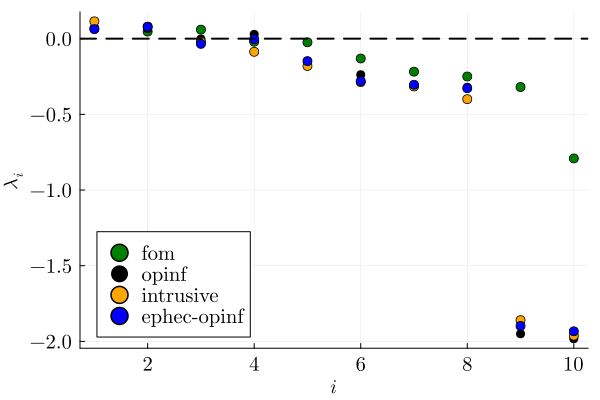

In [164]:
scatter(RES["train_LE"][:fom], c=:green, markersize=5, label="fom")
scatter!(RES["train_LE"][:LS][end], c=:black, markersize=5, label="opinf")
scatter!(RES["train_LE"][:int][end], c=:orange, markersize=5, label="intrusive")
scatter!(RES["train_LE"][:ephec][end], c=:blue, markersize=5, label="ephec-opinf")
# scatter!(RES["train_LE"][:epsic][end], c=:purple, label="epsic-opinf")
# scatter!(RES["train_LE"][:epp][end], c=:red, label="epp-opinf")
hline!([0.0], c=:black, ls=:dash, lw=2, label=false)
xlabel!(L"i")
ylabel!(L"\lambda_i")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [179]:
LE_fom_mean = mean(RES["train_LE"][:fom])
LE_LS_mean = mean(RES["train_LE"][:LS])
LE_int_mean = mean(RES["train_LE"][:int])
LE_ephec_mean = mean(RES["train_LE"][:ephec])
# LE_epsic_mean = mean(RES["train_LE"][:epsic])
# LE_epp_mean = mean(RES["train_LE"][:epp]);
;

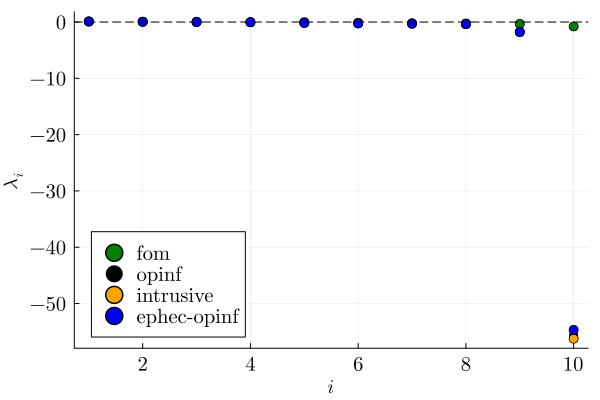

In [181]:
scatter(LE_fom_mean, c=:green, markersize=5, label="fom")
scatter!(LE_LS_mean, c=:black, markersize=5, label="opinf")
scatter!(LE_int_mean, c=:orange, markersize=5, label="intrusive")
scatter!(LE_ephec_mean, c=:blue, markersize=5, label="ephec-opinf")
# scatter!(LE_epsic_mean, c=:purple, label="epsic-opinf")
# scatter!(LE_epp_mean, c=:red, label="epp-opinf")
hline!([0.0], c=:black, ls=:dash, label=false)
xlabel!(L"i")
ylabel!(L"\lambda_i")
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13, legendfontsize=13)

In [182]:
le_df = DataFrame(
    fom=sort(RES["train_LE"][:fom][1], rev=true),
    int=sort(RES["train_LE"][:int][end], rev=true),
    LS=sort(RES["train_LE"][:LS][end], rev=true),
    ephec=sort(RES["train_LE"][:ephec][end], rev=true),
    # epsic=sort(RES["train_LE"][:epsic][end], rev=true),
    # epp=sort(RES["train_LE"][:epp][end], rev=true)
)
le_df

10×4 DataFrame
 Row │ fom         int         LS           ephec       
     │ Float64     Float64     Float64      Float64     
─────┼──────────────────────────────────────────────────
   1 │  0.0680777   0.11459     0.067474     0.0786829
   2 │  0.0599569   0.0794909   0.0664474    0.0628886
   3 │  0.0468746  -0.0194075   0.028585    -0.00330184
   4 │ -0.020174   -0.086756   -0.00191827  -0.034478
   5 │ -0.023878   -0.180532   -0.149015    -0.148319
   6 │ -0.130995   -0.286946   -0.238122    -0.280881
   7 │ -0.218043   -0.315689   -0.315451    -0.304481
   8 │ -0.24987    -0.399459   -0.321007    -0.327548
   9 │ -0.319404   -1.85957    -1.94983     -1.89808
  10 │ -0.791213   -1.96212    -1.98234     -1.93338

### Kaplan–Yorke/Lyapunov Dimension

In [183]:
function compute_Dky(λs::AbstractArray; sorted::Bool=true)
    if !sorted
        λs = sort(λs, rev=true)
    end

    # Find the index where the sum of λ becomes negative
    j = nothing
    tmp = 0
    for (i,λ) in enumerate(λs)
        tmp += λ
        if tmp < 0
            j = i
            break
        end
    end

    if j == nothing
        return length(λs) + sum(λs)
    elseif j == 1
        return 0
    else
        return (j - 1) + sum(λs[1:j-1]) / abs(λs[j])
    end
end


function analyze_Dky(LEs; sorted=true)
    Dky = Array{Float64}(undef, size(LEs)...)
    for i in CartesianIndices(LEs)
        Dky[i] = compute_Dky(LEs[i], sorted=sorted)
    end
    return Dky
end

analyze_Dky (generic function with 1 method)

In [184]:
RES["train_DKY"][:fom] = analyze_Dky(RES["train_LE"][:fom])
RES["train_DKY"][:LS] = analyze_Dky(RES["train_LE"][:LS])
RES["train_DKY"][:int] = analyze_Dky(RES["train_LE"][:int])
RES["train_DKY"][:ephec] = analyze_Dky(RES["train_LE"][:ephec])
# RES["train_DKY"][:epsic] = analyze_Dky(RES["train_LE"][:epsic])
# RES["train_DKY"][:epp] = analyze_Dky(RES["train_LE"][:epp]);
;

In [186]:
dky_df = DataFrame(
    # fom=vec(RES["train_DKY"][:fom]),
    order=vec(DATA["ro"]),
    int=vec(RES["train_DKY"][:int]),
    LS=vec(RES["train_DKY"][:LS]),
    ephec=vec(RES["train_DKY"][:ephec]),
    # epsic=vec(RES["train_DKY"][:epsic]),
    # epp=vec(RES["train_DKY"][:epp])
)
println("FOM Dky:     ", mean(RES["train_DKY"][:fom]))
println("Ref FOM Dky: ", 5.198)
dky_df

FOM Dky:     5.998945439209411
Ref FOM Dky: 5.198


7×4 DataFrame
 Row │ order  int      LS       ephec   
     │ Int64  Float64  Float64  Float64 
─────┼──────────────────────────────────
   1 │     9  6.50676  6.31747  5.88233
   2 │    12  4.8042   0.0      3.855
   3 │    15  4.71297  4.59819  4.6478
   4 │    17  5.34132  4.70603  3.37984
   5 │    20  5.04301  4.64404  4.27807
   6 │    22  4.13512  5.29635  4.42903
   7 │    24  4.48699  5.0486   4.69979

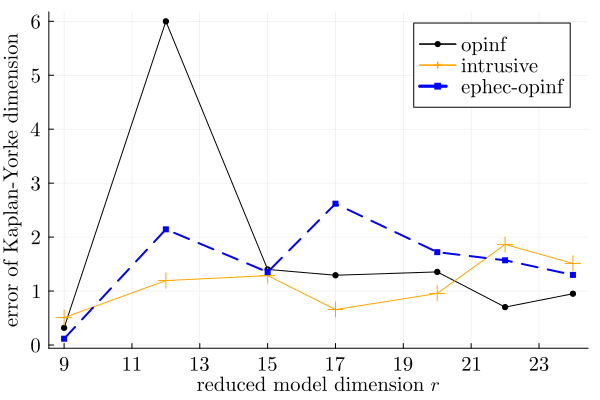

In [188]:
plot(DATA["ro"], abs.(RES["train_DKY"][:LS] .- RES["train_DKY"][:fom]), c=:black, marker=(:circle, 3.5, :black), label="opinf")
plot!(DATA["ro"], abs.(RES["train_DKY"][:int] .- RES["train_DKY"][:fom]), c=:orange, marker=(:cross, 8, :orange), label="intrusive")
plot!(DATA["ro"], abs.(RES["train_DKY"][:ephec] .- RES["train_DKY"][:fom]), c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="ephec-opinf")
# plot!(DATA["ro"], abs.(RES["train_DKY"][:epsic] .- RES["train_DKY"][:fom]), c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label="epsic-opinf")
# plot!(DATA["ro"], abs.(RES["train_DKY"][:epp] .- RES["train_DKY"][:fom]), c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label="epp-opinf")

plot!(majorgrid=true, legend=:topright)
xlabel!("reduced model dimension " * L" r")
ylabel!("error of Kaplan-Yorke dimension")
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=13)


In [261]:
save(resultfile, RES)

### Flow Field Comparison

In [20]:
i = 1
r = DATA["ro"][end]
ic = DATA["IC_train"][i]
Vr = DATA["Vr"][1][:, 1:r]
X_int = KSE.integrate_FD(OPS["op_int"][1].A[1:r, 1:r], LnL.extractF(OPS["op_int"][1].F, r), KSE.t, Vr' * ic)
X_LS = KSE.integrate_FD(OPS["op_LS"][1].A[1:r, 1:r], LnL.extractF(OPS["op_LS"][1].F, r), KSE.t, Vr' * ic)
X_ephec = KSE.integrate_FD(OPS["op_ephec"][1].A[1:r, 1:r], LnL.extractF(OPS["op_ephec"][1].F, r), KSE.t, Vr' * ic)
# X_epsic = KSE.integrate_FD(OPS["op_epsic"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epsic"][1].F, r), KSE.t, Vr' * ic)
# X_epp = KSE.integrate_FD(OPS["op_epp"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epp"][1].F, r), KSE.t, Vr' * ic)
;

In [ ]:
# lout = @layout [a{0.3h}; [grid(2,2)]]
lout = @layout [grid(4,2)]
p_fom = plot(
    contourf(KSE.t[1:DS:end], KSE.x, DATA["Xtr_all"][i][:, 1:DS:end], lw=0,), 
    colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, 
    left_margin=7mm,
    ylabel="fom" * "\n" * L"x"
)
pblank = plot(
    legend=false,grid=false,foreground_color_subplot=:white, left_margin=-3mm, right_margin=-3mm,
)
p_int = plot(
    contourf(KSE.t[1:DS:end], KSE.x, Vr * X_int[:, 1:DS:end], lw=0), 
    colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=7mm,
    ylabel="intrusive" * "\n" * L"x", 
)
p_int_err = plot(
    contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_int[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, top_margin=-2mm
)
p_LS = plot(
    contourf(KSE.t[1:DS:end], KSE.x, Vr * X_LS[:, 1:DS:end], lw=0), 
    colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=7mm,
    ylabel="opinf" * "\n" * L"x",
)
p_LS_err = plot(
    contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_LS[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22),  colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, top_margin=-2mm
)
p_ephec = plot(
    contourf(KSE.t[1:DS:end], KSE.x, Vr * X_ephec[:, 1:DS:end], lw=0), 
    colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm,  bottom_margin=7mm, top_margin=-2mm,
    bottom_margin=5mm, left_margin=7mm,
    ylabel="ep-opinf" * "\n" * L"x", xlabel=L"t"
)
p_ephec_err = plot(
    contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_ephec[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, bottom_margin=7mm,  top_margin=-2mm,
    bottom_margin=5mm,
    xlabel=L"t", 
)
# p_epsic = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epsic[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epsic_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epsic[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))
# p_epp = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epp[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epp_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epp[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))

plot(
    p_fom, pblank, 
    p_int, p_int_err,
    p_LS, p_LS_err,
    p_ephec, p_ephec_err,
    # p_epsic, p_epsic_err,
    # p_epp, p_epp_err, 
    fontfamily="Computer Modern", layout=lout, 
    size=(1200, 650),
    guidefontsize=14, tickfontsize=10
)